In [1]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

PyTorch version: 2.0.1+cpu
NumPy version:  1.24.3
Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


In [2]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


In [9]:
import torch
import torch.nn as nn
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

print(loss_with_penalty)

tensor(0.1108, grad_fn=<AddBackward0>)


In [10]:
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (w Probas) : {bce_loss_fn(probas, target) :.4f}')


print(f'BCE (w Logits): ' f'{bce_logits_loss_fn(logits, target):.4f}')

BCE (w Probas) : 0.3711
BCE (w Logits): 0.3711


In [14]:
# Categorical Cross Entropy
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim = 1)
target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w probas): '
      f'{cce_logits_loss_fn(logits, target):.4f}')

print(f'CCE (w Logits): '
      f'{cce_loss_fn(torch.log(probas), target):.2f}')

CCE (w probas): 0.5996
CCE (w Logits): 0.5996


In [15]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

In [16]:
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=False
)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))

mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,train=False, transform=transform, download=False)


In [20]:
from torch.utils.data import DataLoader
batch_size = 64

torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset,
                      batch_size,
                      shuffle=True)

valid_dl = DataLoader(mnist_valid_dataset,
                      batch_size,
                      shuffle=False)

In [22]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)

model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding = 2
    )
)

model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2)) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl: 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
            print(f'Epoch {epoch+1} accuracy:'
               f'{accuracy_hist_train[epoch]:.4f} val_accuracy:'
               f'{accuracy_hist_valid[epoch]:.4f}')
            
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [25]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model,num_epochs,train_dl,valid_dl)

Epoch 1 accuracy:0.9505 val_accuracy:0.9831
Epoch 2 accuracy:0.9841 val_accuracy:0.9870
Epoch 3 accuracy:0.9888 val_accuracy:0.9887
Epoch 4 accuracy:0.9920 val_accuracy:0.9897
Epoch 5 accuracy:0.9928 val_accuracy:0.9891
Epoch 6 accuracy:0.9951 val_accuracy:0.9902
Epoch 7 accuracy:0.9953 val_accuracy:0.9907
Epoch 8 accuracy:0.9956 val_accuracy:0.9910
Epoch 9 accuracy:0.9964 val_accuracy:0.9918
Epoch 10 accuracy:0.9969 val_accuracy:0.9893
Epoch 11 accuracy:0.9965 val_accuracy:0.9902
Epoch 12 accuracy:0.9972 val_accuracy:0.9898
Epoch 13 accuracy:0.9982 val_accuracy:0.9905
Epoch 14 accuracy:0.9979 val_accuracy:0.9919
Epoch 15 accuracy:0.9972 val_accuracy:0.9912
Epoch 16 accuracy:0.9977 val_accuracy:0.9905
Epoch 17 accuracy:0.9977 val_accuracy:0.9915
Epoch 18 accuracy:0.9986 val_accuracy:0.9902
Epoch 19 accuracy:0.9984 val_accuracy:0.9912
Epoch 20 accuracy:0.9984 val_accuracy:0.9926


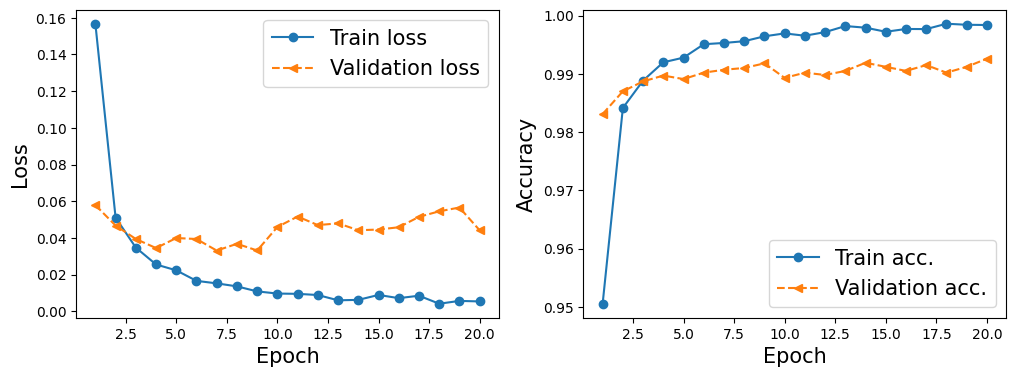

In [27]:
import matplotlib.pyplot as plt

import numpy as np
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [28]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9923


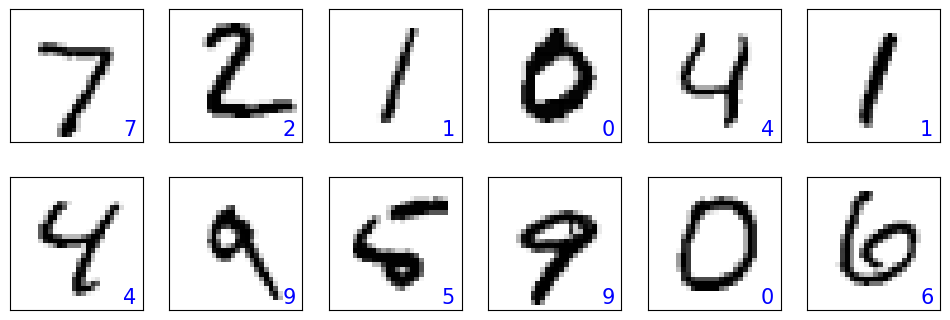

In [29]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()